In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, f1_score, precision_score, recall_score, auc, roc_curve, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

pd.options.display.max_columns = 50

import warnings
warnings.filterwarnings('ignore')

In [33]:
train_df = pd.read_csv('train_df_preprocessed.csv')
test_df = pd.read_csv('test_df_preprocessed.csv')
submission = pd.read_csv('sample_submission.csv')

# Assigning Target and Independent Variables

In [3]:
train_df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited,Surname_tfidf_0,Surname_tfidf_1,Surname_tfidf_2,CustomerValueIndex,Geography_Germany,Geography_Spain,Gender_Male,AgeBin_30-39,AgeBin_40-49,AgeBin_50-59,AgeBin_60-69,AgeBin_70-79,AgeBin_80-93,SalaryGroup_medium,SalaryGroup_high,SalaryGroup_very high
0,0.636,0.202703,0.3,0.000000,0.333333,1.0,0.0,0,-4.286143e-07,-2.015483e-06,-2.026255e-06,0.002597,0,0,1,1,0,0,0,0,0,0,0,1
1,0.554,0.202703,0.1,0.000000,0.333333,1.0,1.0,0,9.029183e-08,1.301587e-06,2.378668e-06,0.006852,0,0,1,1,0,0,0,0,0,0,0,0
2,0.656,0.297297,1.0,0.000000,0.333333,1.0,0.0,0,-7.716436e-04,1.257349e-02,1.109867e-03,0.000663,0,0,1,0,1,0,0,0,0,0,0,1
3,0.462,0.216216,0.2,0.958023,0.000000,1.0,1.0,0,6.096764e-04,1.043350e-02,2.368227e-02,0.244141,0,0,1,1,0,0,0,0,0,1,0,0
4,0.732,0.202703,0.5,0.000000,0.333333,1.0,1.0,0,2.872939e-07,6.476190e-07,-3.330512e-07,0.001989,0,1,1,1,0,0,0,0,0,0,0,0


In [4]:
X_train = train_df.drop(columns='Exited')
y_train = train_df['Exited']

X_test = test_df

# Modelling

Remember there is significant class imbalance in the dataset, we need to apply resampling method in order for mitigate the bias and underperformance of the model on the minority class. I will compare undersampling and oversampling method below.

## Base Models

Incorporating resampling methods like Random Under-Sampling or SMOTE (Synthetic Minority Over-sampling Technique) should be done within cross-validation loops, which is crucial for several reasons:
- Bias Avoidance: Applying resampling methods outside of the cross-validation loop can lead to information leakage from the validation set into the training set. This can bias the model to perform artificially well on the validation set because it has "seen" some of the validation data during training. Incorporating resampling within each fold of cross-validation ensures that the oversampling or undersampling is done independently in each iteration, keeping the validation set strictly separate.
- Accurate Model Evaluation: When resampling methods are applied within the cross-validation loop, each fold of the model is trained and validated on a balanced dataset, providing a more accurate evaluation of how the model performs on balanced data. This is particularly important for imbalanced datasets where performance metrics might be skewed if the imbalance is not addressed.
- Better Generalization: Models trained and validated on resampled datasets within cross-validation loops tend to generalize better to unseen data. This is because the resampling process, when done correctly, helps the model learn more about the minority class, improving its ability to predict minority class instances in new datasets.

In [83]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0),
    'Extra Trees': ExtraTreesClassifier(),
    'LightGBM': lgb.LGBMClassifier(),
    'XGB': xgb.XGBClassifier()
}

results = {
    'RandomUnderSampler': {'AUC': {}, 'Time': {}},
    'SMOTE': {'AUC': {}, 'Time': {}}
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# loop through each sampling strategy
for strategy_name, resampler in [('RandomUnderSampler', RandomUnderSampler(random_state=42)),
                               ('SMOTE', SMOTE(random_state=42))]:
    
    for model_name, model in models.items():
        print(f"Processing {model_name} with {strategy_name}...")
        auc_scores = []
        start_time = time.time()
        
        for train_index, test_index in kf.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

            # apply the chosen sampling strategy
            X_train_rs, y_train_rs = resampler.fit_resample(X_train_fold, y_train_fold)

            # fit and evaluate the model
            model.fit(X_train_rs, y_train_rs)
            y_pred_prob = model.predict_proba(X_val_fold)[:, 1]
            auc = roc_auc_score(y_val_fold, y_pred_prob)
            auc_scores.append(auc)
            
            print(f"Fold AUC: {auc:.4f}")
            
        duration = time.time() - start_time
        avg_auc = np.mean(auc_scores)

        # Store results
        results[strategy_name]['AUC'][model_name] = avg_auc
        results[strategy_name]['Time'][model_name] = duration

        print(f"Average AUC: {avg_auc:.4f}, Run Time: {duration:.2f} seconds")
        print('='*50)
        print('\n')

Processing Logistic Regression with RandomUnderSampler...
Fold AUC: 0.8265
Fold AUC: 0.8274
Fold AUC: 0.8276
Fold AUC: 0.8281
Fold AUC: 0.8325
Average AUC: 0.8284, Run Time: 1.83 seconds


Processing KNN with RandomUnderSampler...
Fold AUC: 0.8294
Fold AUC: 0.8263
Fold AUC: 0.8262
Fold AUC: 0.8262
Fold AUC: 0.8315
Average AUC: 0.8279, Run Time: 5.79 seconds


Processing Decision Tree with RandomUnderSampler...
Fold AUC: 0.7253
Fold AUC: 0.7237
Fold AUC: 0.7294
Fold AUC: 0.7258
Fold AUC: 0.7275
Average AUC: 0.7263, Run Time: 2.50 seconds


Processing Random Forest with RandomUnderSampler...
Fold AUC: 0.8770
Fold AUC: 0.8754
Fold AUC: 0.8799
Fold AUC: 0.8765
Fold AUC: 0.8802
Average AUC: 0.8778, Run Time: 34.11 seconds


Processing CatBoost with RandomUnderSampler...
Fold AUC: 0.8914
Fold AUC: 0.8901
Fold AUC: 0.8943
Fold AUC: 0.8898
Fold AUC: 0.8941
Average AUC: 0.8919, Run Time: 26.05 seconds


Processing Extra Trees with RandomUnderSampler...
Fold AUC: 0.8619
Fold AUC: 0.8616
Fold AUC

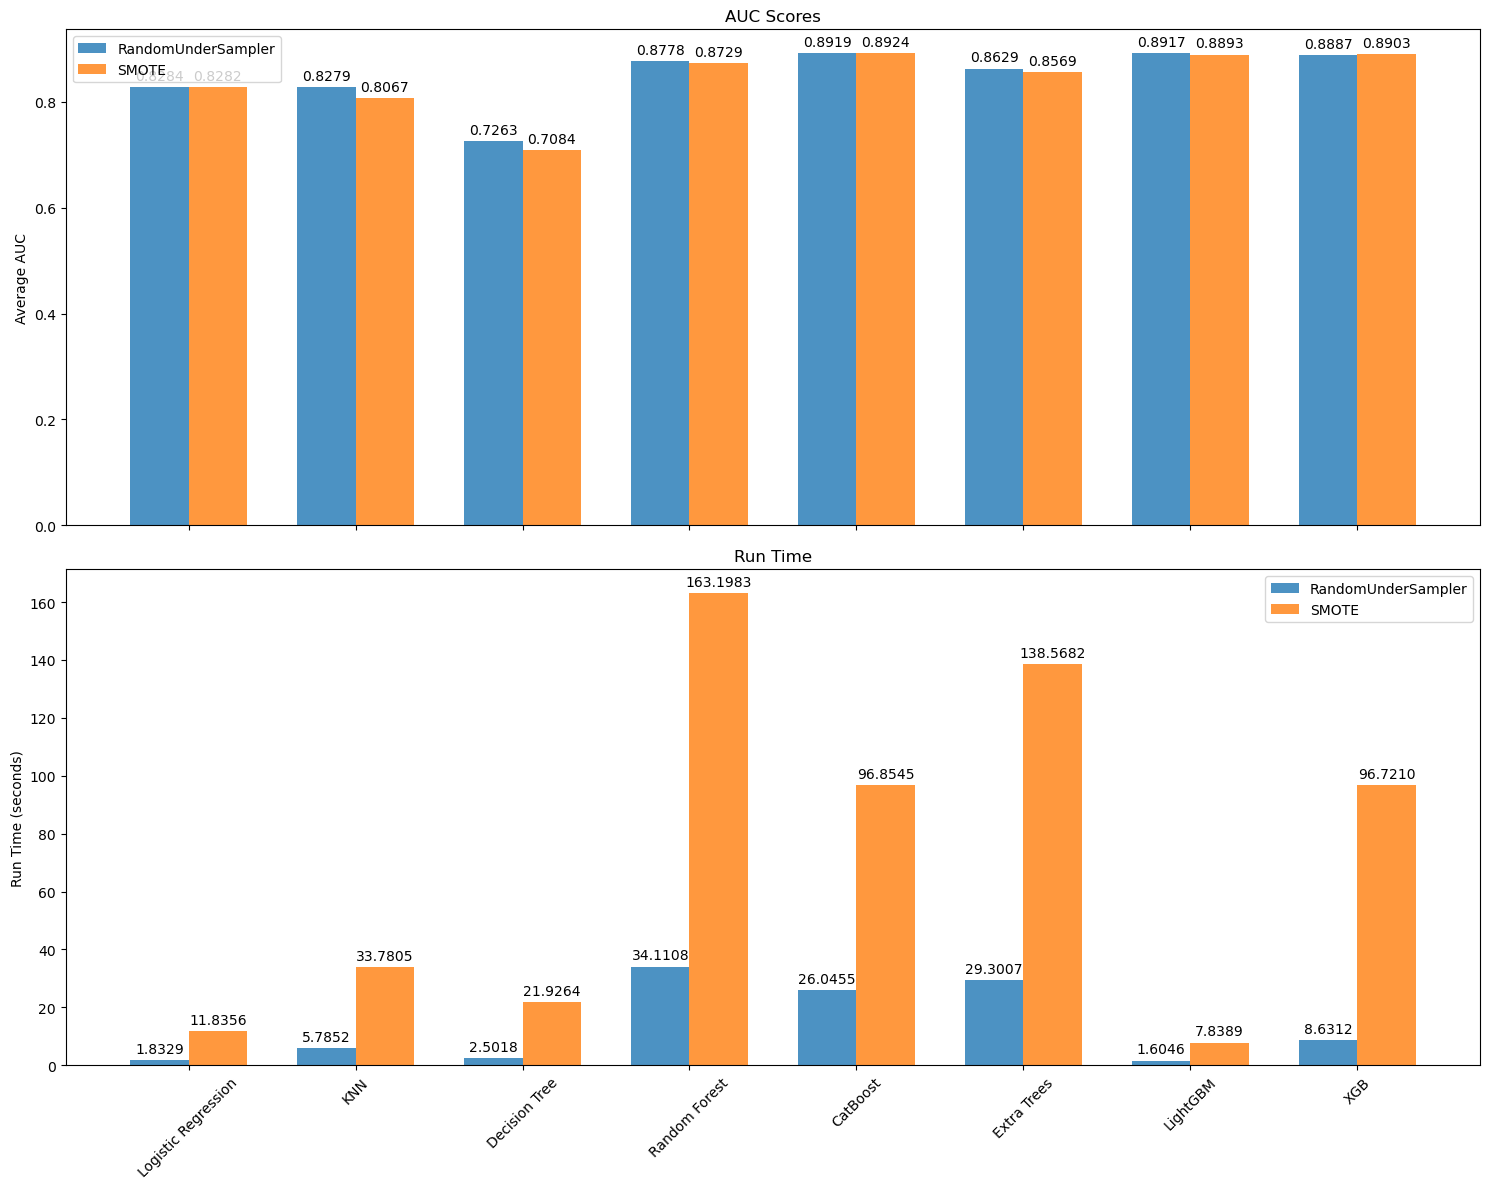

In [84]:
# visulize the model scores and run time to compare
fig, axs = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

model_names = list(models.keys())
strategies = ['RandomUnderSampler', 'SMOTE']
n_groups = len(model_names)
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

# function to add value labels above each bar
def add_value_labels(ax, rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# AUC plot
for i, strategy in enumerate(strategies):
    auc_scores = [results[strategy]['AUC'][model] for model in model_names]
    rects = axs[0].bar(index + i*bar_width, auc_scores, bar_width, alpha=opacity, label=strategy)
    add_value_labels(axs[0], rects)

# run time plot
for i, strategy in enumerate(strategies):
    run_times = [results[strategy]['Time'][model] for model in model_names]
    rects = axs[1].bar(index + i*bar_width, run_times, bar_width, alpha=opacity, label=strategy)
    add_value_labels(axs[1], rects)

# plot titles and labels
axs[0].set_title('AUC Scores')
axs[0].set_ylabel('Average AUC')
axs[1].set_title('Run Time')
axs[1].set_ylabel('Run Time (seconds)')
plt.xticks(index + bar_width / 2, model_names, rotation=45)

# adding legends
axs[0].legend()
axs[1].legend()

plt.tight_layout()
plt.show()

CatBoostClassifier and LightGBM with RandomUnderSampler stand out as strong candidates for further tuning. CatBoostClassifier scored the highest AUC of 0.8919, but the run time of LightGBM (13 seconds) is significantly lower than CatBoostClassfier, making it more computationally efficient to train, and it might be easier to tune and deploy in a production environment due to its efficiency.

# Hyperparameter Tuning

In [8]:
np.arange(0.2, 1.1, 0.1)

array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [59]:
# set up pipeline with placeholders
pipeline = imbpipeline(steps = [['resampler', RandomUnderSampler()],
                                ['model', lgb.LGBMClassifier()]])

# set up a hyperparameter grid 
param_grid =[ 
    {
        'resampler': [RandomUnderSampler(random_state=42)],
        'model__boosting_type': ['gbdt'], 
        'model__num_leaves': np.arange(11, 51, 10), 
        'model__max_depth': np.arange(-1, 100, 5),
        'model__learning_rate': [0.001, 0.01, 0.1, 1],
        'model__n_estimators':np.arange(500, 1000, 20),
        'model__min_split_gain': np.arange(0, 1, 0.1),
        'model__min_child_weight': [10, 20, 30, 40, 50, 60, 100],
        'model__subsample': np.arange(0.1, 1.0, 0.1), 
        'model__reg_alpha': np.logspace(-5,2,8),
        'model__reg_lambda': np.logspace(-5,2,8),
        'model__colsample_bytree': np.arange(0.3, 1.0, 0.1)
    }
]


# set up stratifiedkfold for cross validation
stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=42)

# instantiate gridsearch search
rscv =RandomizedSearchCV(estimator=pipeline,
                  param_distributions=param_grid,
                  scoring='roc_auc',
                  cv=stratified_kfold,
                  n_jobs=-1)

# fit
rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[['resampler',
                                              RandomUnderSampler()],
                                             ['model', LGBMClassifier()]]),
                   n_jobs=-1,
                   param_distributions=[{'model__boosting_type': ['gbdt'],
                                         'model__colsample_bytree': array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                         'model__learning_rate': [0.001, 0.01,
                                                                  0.1, 1],
                                         'model__max_...
       760, 780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980]),
                                         'model__num_leaves': array([11, 21, 31, 41]),
                                         'model__reg_alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                                         'model__reg_lambda': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                                         'model__subsample': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                         'resampler': [RandomUnderSampler(random_state=42)]}],
                   scoring='roc_auc')

In [60]:
# Print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", rscv.best_params_)
print("Best Score: ", rscv.best_score_)

Best Hyperparameters:  {'resampler': RandomUnderSampler(random_state=42), 'model__subsample': 0.1, 'model__reg_lambda': 0.1, 'model__reg_alpha': 1.0, 'model__num_leaves': 31, 'model__n_estimators': 580, 'model__min_split_gain': 0.6000000000000001, 'model__min_child_weight': 50, 'model__max_depth': 64, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.7000000000000002, 'model__boosting_type': 'gbdt'}
Best Score:  0.8924051573116941


Check the model metrics on the cross-validation.

In [81]:
train_acc = []
val_acc = []
precision = []
recall = []
f1 = []
roc_auc = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
us = RandomUnderSampler(random_state=42)

for train_index, test_index in kf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # apply undersampling
    X_train_fold, y_train_fold = us.fit_resample(X_train_fold, y_train_fold)

    # predict on training set
    y_train_pred = rscv.best_estimator_.predict(X_train_fold)
    y_train_pred_proba = rscv.best_estimator_.predict_proba(X_train_fold)[:, 1]

    # predict on val set
    y_val_pred = rscv.best_estimator_.predict(X_val_fold)
    y_val_pred_proba = rscv.best_estimator_.predict_proba(X_val_fold)[:, 1]

    # calculate metrics
    train_acc.append(accuracy_score(y_train_fold, y_train_pred))
    val_acc.append(accuracy_score(y_val_fold, y_val_pred))
    precision.append(precision_score(y_val_fold, y_val_pred))
    recall.append(recall_score(y_val_fold, y_val_pred))
    f1.append(f1_score(y_val_fold, y_val_pred))
    roc_auc.append(roc_auc_score(y_val_fold, y_val_pred_proba))
    

# print training metrics
print(f"Train Accuracy: {np.mean(train_acc):.2f}")
print(f"Validation Accuracy: {np.mean(val_acc):.2f}")
print(f"Precision: {np.mean(precision):.2f}")
print(f"Recall: {np.mean(recall):.2f}")
print(f"F1 Score: {np.mean(f1):.2f}")
print(f"ROC AUC: {np.mean(roc_auc):.2f}")

Train Accuracy: 0.82
Validation Accuracy: 0.82
Precision: 0.55
Recall: 0.81
F1 Score: 0.65
ROC AUC: 0.90


# Feature Importance

In [85]:
# Assuming your best model is accessible and supports feature importance
best_model = rscv.best_estimator_.named_steps['model']

# Feature importance
feature_importance = best_model.feature_importances_

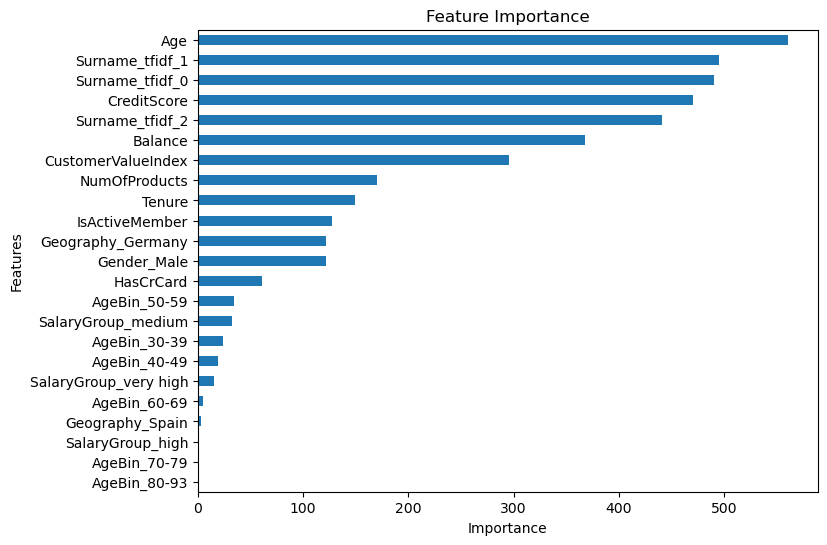

In [95]:
# Ensure the feature names match the order in which they were used for training
feature_names = X_train.columns

# Create a pandas Series for easier plotting
importance_series = pd.Series(feature_importance, index=feature_names)

# Sort the features by importance
sorted_importance = importance_series.sort_values(ascending=True)

# Plotting
plt.figure(figsize=(8,6))
sorted_importance.plot(kind='barh')
plt.title('Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.show()

# Predict on Submission Sets

In [65]:
# instantiate optimized model and resampler
best_model = rscv.best_estimator_

submission_predictions = []

y_val_pred = best_model.predict_proba(X_test)[:,1]

submission_predictions.append(y_test_pred)    

In [66]:
avg_submission_predictions = pd.DataFrame(submission_predictions).mean(axis=0)

submission['Exited'] = avg_submission_predictions

In [82]:
submission.head(10)

,id,Exited
0,165034,0.047733
1,165035,0.908932
2,165036,0.107293
3,165037,0.600782
4,165038,0.708028
5,165039,0.236400
6,165040,0.112634
7,165041,0.313409
8,165042,0.887527
9,165043,0.020730
